# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt

from agent import Agent
from collections import deque
from unityagents import UnityEnvironment

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
env = UnityEnvironment(file_name='../Reacher_Linux/Reacher.x86_64', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [6]:
def ddpg(n_episodes=2000, max_t=1000):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores = np.zeros(num_agents)
    scores_episode = []
    
    agents =[] 
    for i in range(num_agents):
        agents.append(Agent(state_size, action_size, random_seed=2))
    
    for i_episode in range(1, n_episodes+1):
        start = time.time()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        for agent in agents:
            agent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = np.array([agents[i].act(states[i]) for i in range(num_agents)])
            env_info = env.step(actions)[brain_name]       
            next_states = env_info.vector_observations    
            rewards = env_info.rewards
            dones = env_info.local_done        
            for i in range(num_agents):
                agents[i].step(t,states[i], actions[i], rewards[i], next_states[i], dones[i]) 
            states = next_states
            scores += rewards
            if t % 20:
                print('\rTimestep {}\tScore: {:.2f}\tmin: {:.2f}\tmax: {:.2f}'
                      .format(t, np.mean(scores), np.min(scores), np.max(scores)), end="") 
            if np.any(dones):
                break 
        score = np.mean(scores)
        scores_window.append(score)
        scores_episode.append(score)
        end = time.time()
        print(f'\rEpisode {i_episode}\tScore: {score:.2f}\tAverage Score: {np.mean(scores_window):.2f}\tTime: {(end - start):.2f}')
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window)>=30.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(Agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(Agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores_episode

scores = ddpg()


Episode 1	Score: 0.16	Average Score: 0.16	Time: 4.75
Episode 2	Score: 0.99	Average Score: 0.57	Time: 5.13
Episode 3	Score: 0.49	Average Score: 0.55	Time: 5.11
Episode 4	Score: 0.67	Average Score: 0.58	Time: 5.12
Episode 5	Score: 0.08	Average Score: 0.48	Time: 5.11
Episode 6	Score: 0.38	Average Score: 0.46	Time: 5.08
Episode 7	Score: 0.91	Average Score: 0.53	Time: 5.12
Episode 8	Score: 0.24	Average Score: 0.49	Time: 5.18
Episode 9	Score: 0.00	Average Score: 0.44	Time: 5.13
Episode 10	Score: 0.53	Average Score: 0.44	Time: 5.35
Episode 11	Score: 0.37	Average Score: 0.44	Time: 5.48
Episode 12	Score: 0.00	Average Score: 0.40	Time: 5.22
Episode 13	Score: 0.13	Average Score: 0.38	Time: 5.15
Episode 14	Score: 0.17	Average Score: 0.37	Time: 5.15
Episode 15	Score: 0.00	Average Score: 0.34	Time: 5.14
Episode 16	Score: 0.99	Average Score: 0.38	Time: 5.19
Episode 17	Score: 0.55	Average Score: 0.39	Time: 5.21
Episode 18	Score: 0.62	Average Score: 0.40	Time: 5.17
Episode 19	Score: 1.27	Average Score:

Episode 299	Score: 9.46	Average Score: 6.08	Time: 5.59
Episode 300	Score: 7.83	Average Score: 6.08	Time: 5.58
Episode 300	Average Score: 6.08
Episode 301	Score: 10.74	Average Score: 6.13	Time: 5.58
Episode 302	Score: 5.67	Average Score: 6.14	Time: 5.61
Episode 303	Score: 5.59	Average Score: 6.17	Time: 5.69
Episode 304	Score: 9.59	Average Score: 6.22	Time: 5.69
Episode 305	Score: 4.23	Average Score: 6.16	Time: 5.60
Episode 306	Score: 7.07	Average Score: 6.16	Time: 5.59
Episode 307	Score: 9.64	Average Score: 6.19	Time: 5.57
Episode 308	Score: 5.83	Average Score: 6.22	Time: 5.63
Episode 309	Score: 8.37	Average Score: 6.22	Time: 5.63
Episode 310	Score: 5.06	Average Score: 6.22	Time: 5.56
Episode 311	Score: 9.20	Average Score: 6.24	Time: 5.62
Episode 312	Score: 4.65	Average Score: 6.23	Time: 5.71
Episode 313	Score: 12.18	Average Score: 6.30	Time: 5.60
Episode 314	Score: 10.73	Average Score: 6.36	Time: 5.59
Episode 315	Score: 5.93	Average Score: 6.38	Time: 5.59
Episode 316	Score: 6.04	Averag

Episode 593	Score: 5.75	Average Score: 10.07	Time: 5.97
Episode 594	Score: 3.03	Average Score: 9.98	Time: 5.97
Episode 595	Score: 8.84	Average Score: 9.99	Time: 6.03
Episode 596	Score: 8.40	Average Score: 9.98	Time: 5.96
Episode 597	Score: 9.27	Average Score: 10.00	Time: 6.04
Episode 598	Score: 6.99	Average Score: 9.98	Time: 6.10
Episode 599	Score: 9.55	Average Score: 10.00	Time: 5.98
Episode 600	Score: 10.32	Average Score: 10.03	Time: 5.97
Episode 600	Average Score: 10.03
Episode 601	Score: 10.62	Average Score: 10.05	Time: 5.99
Episode 602	Score: 9.52	Average Score: 10.06	Time: 6.05
Episode 603	Score: 9.23	Average Score: 10.05	Time: 6.02
Episode 604	Score: 12.67	Average Score: 10.07	Time: 6.00
Episode 605	Score: 7.81	Average Score: 10.10	Time: 6.04
Episode 606	Score: 9.01	Average Score: 10.12	Time: 5.98
Episode 607	Score: 12.20	Average Score: 10.24	Time: 6.05
Episode 608	Score: 6.74	Average Score: 10.22	Time: 6.17
Episode 609	Score: 9.61	Average Score: 10.19	Time: 6.11
Episode 610	Sco

Episode 880	Score: 13.36	Average Score: 14.14	Time: 6.78
Episode 881	Score: 13.17	Average Score: 14.12	Time: 6.83
Episode 882	Score: 16.19	Average Score: 14.18	Time: 6.83
Episode 883	Score: 20.73	Average Score: 14.23	Time: 6.90
Episode 884	Score: 14.99	Average Score: 14.24	Time: 6.96
Episode 885	Score: 9.92	Average Score: 14.19	Time: 6.80
Episode 886	Score: 11.50	Average Score: 14.06	Time: 6.79
Episode 887	Score: 16.66	Average Score: 14.10	Time: 6.79
Episode 888	Score: 12.75	Average Score: 14.10	Time: 6.82
Episode 889	Score: 15.78	Average Score: 14.13	Time: 6.82
Episode 890	Score: 13.03	Average Score: 14.10	Time: 6.78
Episode 891	Score: 27.98	Average Score: 14.22	Time: 6.82
Episode 892	Score: 16.08	Average Score: 14.26	Time: 6.88
Episode 893	Score: 13.79	Average Score: 14.28	Time: 6.90
Episode 894	Score: 13.95	Average Score: 14.23	Time: 6.82
Episode 895	Score: 14.98	Average Score: 14.22	Time: 6.84
Episode 896	Score: 21.09	Average Score: 14.33	Time: 6.83
Episode 897	Score: 15.38	Average

Episode 1163	Score: 15.23	Average Score: 15.15	Time: 7.01
Episode 1164	Score: 1.20	Average Score: 14.99	Time: 7.17
Episode 1165	Score: 14.70	Average Score: 14.95	Time: 7.09
Episode 1166	Score: 27.32	Average Score: 15.11	Time: 7.15
Episode 1167	Score: 18.66	Average Score: 15.19	Time: 7.10
Episode 1168	Score: 13.01	Average Score: 15.16	Time: 7.06
Episode 1169	Score: 13.10	Average Score: 15.13	Time: 7.18
Episode 1170	Score: 13.86	Average Score: 15.11	Time: 7.43
Episode 1171	Score: 13.25	Average Score: 15.08	Time: 7.18
Episode 1172	Score: 17.32	Average Score: 15.13	Time: 7.09
Episode 1173	Score: 20.02	Average Score: 15.16	Time: 7.09
Episode 1174	Score: 14.49	Average Score: 15.16	Time: 7.05
Episode 1175	Score: 1.70	Average Score: 15.09	Time: 7.03
Episode 1176	Score: 17.33	Average Score: 14.95	Time: 7.11
Episode 1177	Score: 12.07	Average Score: 14.88	Time: 7.10
Episode 1178	Score: 15.71	Average Score: 14.90	Time: 7.12
Episode 1179	Score: 14.42	Average Score: 14.90	Time: 7.06
Episode 1180	Sco

Episode 1443	Score: 17.97	Average Score: 18.31	Time: 7.37
Episode 1444	Score: 18.20	Average Score: 18.31	Time: 7.23
Episode 1445	Score: 21.75	Average Score: 18.36	Time: 7.23
Episode 1446	Score: 20.47	Average Score: 18.40	Time: 7.31
Episode 1447	Score: 16.74	Average Score: 18.40	Time: 7.37
Episode 1448	Score: 20.60	Average Score: 18.44	Time: 7.30
Episode 1449	Score: 21.68	Average Score: 18.44	Time: 7.28
Episode 1450	Score: 17.07	Average Score: 18.45	Time: 7.22
Episode 1451	Score: 20.63	Average Score: 18.45	Time: 7.23
Episode 1452	Score: 15.39	Average Score: 18.40	Time: 7.26
Episode 1453	Score: 15.75	Average Score: 18.36	Time: 7.21
Episode 1454	Score: 22.21	Average Score: 18.40	Time: 7.23
Episode 1455	Score: 19.17	Average Score: 18.39	Time: 7.24
Episode 1456	Score: 21.98	Average Score: 18.44	Time: 7.27
Episode 1457	Score: 32.05	Average Score: 18.56	Time: 7.26
Episode 1458	Score: 20.82	Average Score: 18.61	Time: 7.25
Episode 1459	Score: 11.12	Average Score: 18.56	Time: 7.30
Episode 1460	S

Episode 1723	Score: 18.35	Average Score: 19.19	Time: 7.12
Episode 1724	Score: 20.26	Average Score: 19.17	Time: 7.13
Episode 1725	Score: 18.15	Average Score: 19.18	Time: 7.13
Episode 1726	Score: 17.71	Average Score: 19.18	Time: 7.13
Episode 1727	Score: 22.43	Average Score: 19.23	Time: 7.16
Episode 1728	Score: 20.89	Average Score: 19.21	Time: 7.20
Episode 1729	Score: 18.83	Average Score: 19.18	Time: 7.11
Episode 1730	Score: 20.35	Average Score: 19.31	Time: 7.04
Episode 1731	Score: 17.55	Average Score: 19.30	Time: 7.05
Episode 1732	Score: 18.13	Average Score: 19.31	Time: 7.25
Episode 1733	Score: 19.41	Average Score: 19.30	Time: 7.46
Episode 1734	Score: 20.69	Average Score: 19.29	Time: 7.11
Episode 1735	Score: 22.43	Average Score: 19.32	Time: 7.15
Episode 1736	Score: 20.07	Average Score: 19.30	Time: 7.10
Episode 1737	Score: 23.15	Average Score: 19.32	Time: 7.13
Episode 1738	Score: 21.25	Average Score: 19.30	Time: 7.12
Episode 1739	Score: 13.28	Average Score: 19.26	Time: 7.29
Episode 1740	S

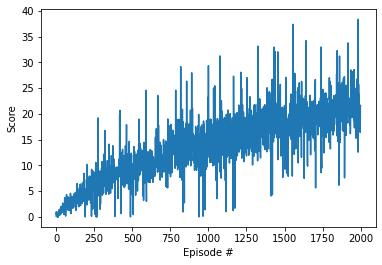

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [8]:
env.close()